# Visualization

Probability density function is `f(x, y) = c * x * y` where 'c' is a constant, 'x' and 'y' are random variables from set Omega, where `Omega = { (x, y) | 1 < x < y < 2 }`.


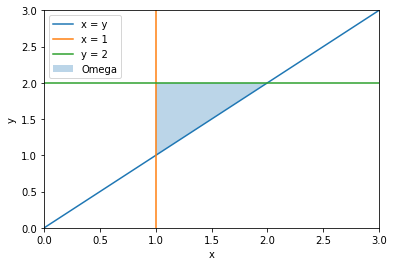

In [1]:
import numpy as np
import math
import pylab
from matplotlib import pyplot as plt

# We get three equations:
# 1)    x > 1
# 2)    x < y
# 3)    y < 2

# From this we can derive that x will go from 1 to y and y will go from x to 2
# Therefore x will go from 1 to 2 and y will go from 1 to 2 as well
# To plot this we simply use the three functions with = instead of < or > and intersect them

x_range = np.linspace(1, 2, 1000)  # range of random variable X
sampling_range = np.linspace(0, 3, 1000)  # range of lines for visualization
f1 = sampling_range
# f2 will simply be plotted as a line because it is not a y = f(x) function
f3 = 2 * np.ones_like(sampling_range)

plt.plot(sampling_range, f1, label='x = y')
plt.plot((1, 1), (0, 3), label='x = 1')
plt.plot(sampling_range, f3, label='y = 2')

plt.fill_between(x_range, x_range, 2 * np.ones_like(x_range), alpha=0.3, label=r'Omega')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(left=0, right=3)
plt.ylim(bottom=0, top=3)

plt.savefig('omega_vis.png', dpi=600)
plt.show()

# Generator implementation


## General idea

For generating numbers from Omega we will use the rejection method.

In [2]:
import numpy as np

_const_c = 8/9
def f(x):
    """
    Density probability function
    Note that here "x" is a 2 element vector (i.e. variables X and Y)
    """
    return _const_c * x[0] * x[1]


Calculate max value of the probability function

In [3]:
fx_max = f((2, 2))

fx_max

3.5555555555555554

In [4]:
# Use this to generate random numbers with consistent seed
seed = 66
np_rng = np.random.default_rng(seed=seed)


Proof of concept of generating samples

In [5]:

# We will generate 100 samples
n_samples = 100

# Our x1 and x2 ranges are the same - from 1 to 2
xi_range = 1, 2

x1 = np_rng.uniform(*xi_range, size=n_samples)
x2 = np_rng.uniform(*xi_range, size=n_samples)
fx = np_rng.uniform(0, fx_max, size=n_samples)

# For simplicity create a matrix - each row is a sample of (x1, x2, fx)
samples = np.stack((x1, x2, fx), axis=1)

samples[:10]

array([[1.92373388, 1.51040136, 2.61800176],
       [1.69281813, 1.98988977, 2.58481953],
       [1.07293478, 1.16414471, 2.58183818],
       [1.62425381, 1.12028687, 1.46488514],
       [1.4725191 , 1.03945343, 2.27199935],
       [1.84901876, 1.26977353, 3.44762782],
       [1.10282827, 1.17467894, 3.43794991],
       [1.43752488, 1.68611076, 1.41176016],
       [1.46004468, 1.22352332, 0.28152982],
       [1.90878931, 1.27451867, 0.71716336]])

In [6]:
samples.shape

(100, 3)

To filter accepted values we can use following condition which will return a boolean array. Since we already generate from correct ranges we only need to ensure that x < y

In [7]:

accepted_filter = (np.apply_along_axis(f,1,samples) < samples[:, 2]) & (samples[:, 0] < samples[:, 1])
accepted = samples[accepted_filter]
accepted[:10]

array([[1.07293478, 1.16414471, 2.58183818],
       [1.10282827, 1.17467894, 3.43794991],
       [1.13803906, 1.46912417, 3.26260474],
       [1.22959056, 1.76988753, 2.3478668 ],
       [1.14288465, 1.45965636, 2.88048124],
       [1.25370907, 1.94948465, 2.30614333],
       [1.46925391, 1.90646712, 3.13749715],
       [1.09264071, 1.22133779, 3.03442874],
       [1.196885  , 1.34512349, 3.51723878],
       [1.0115308 , 1.86595125, 2.6435471 ]])

In [8]:
accepted_filter[:10]

array([False, False,  True, False, False, False,  True, False, False,
       False])

Analogically, rejected items can be obtaining by negating the condition

In [9]:
rejected_filter = ~((np.apply_along_axis(f,1,samples) < samples[:, 2]) & (samples[:, 0] < samples[:, 1]))
rejected = samples[rejected_filter]
rejected[:10]

array([[1.92373388, 1.51040136, 2.61800176],
       [1.69281813, 1.98988977, 2.58481953],
       [1.62425381, 1.12028687, 1.46488514],
       [1.4725191 , 1.03945343, 2.27199935],
       [1.84901876, 1.26977353, 3.44762782],
       [1.43752488, 1.68611076, 1.41176016],
       [1.46004468, 1.22352332, 0.28152982],
       [1.90878931, 1.27451867, 0.71716336],
       [1.79177719, 1.18483522, 1.77765827],
       [1.5297229 , 1.59680124, 0.18458611]])

In [10]:
rejected_filter[:10]

array([ True,  True, False,  True,  True,  True, False,  True,  True,
        True])

Negating rejected filter must give us the accepted filter

In [11]:
np.all(accepted_filter == ~rejected_filter)

True

## Value generation

In [12]:
def generate_batch(n_tries=10_000, rng=np_rng):
    """
    Generates batch of samples from the distribution

    Args:
        fx_max float: max_value of fx
        tries: number of samples that are generated
        rng: rng generator. Defaults to np_rng.

    Returns:
        _type_: _description_
    """
    # x1 and x2 have the same range - from 1 to 2
    start, end = 1, 2
    fx_max = f((2, 2))  # calculate max value of fx
    
    # Generate vector (matrix) u which will contain x1 and x2
    u = np_rng.uniform(0, 1, 2*n_tries)
    
    # Since x1 and x2 and have same range we can simply generate 2*count vector and then split it into two vectors
    u = u.reshape(-1, 2)
    
    # Adjust scaling
    x = start + (end - start) * u
    
    # Generate "v" vector which contains function values
    v = np_rng.uniform(0, 1, n_tries)
    
    # Not calling function f and computing it in-place like so will save us irrelevant msecs
    fx = x[:, 0] * x[:, 1]
    
    # Finally filter out only accepted samples - i.e. f(x) < v * fx_max and x1 < x2
    return x[(v * fx_max < fx) & (x[:, 0] < x[:, 1])]
    

def generate_n_samples(n_samples):
    """
    Generates N samples from the distribution. Note that hardcoding batch size is not the most efficient idea
    and would probably take some tweaking to get the best performance.
    Args:
        n_samples (int): number of samples to generate
        rng (_type_, optional): _description_. Defaults to np.np_rng.
    """
    
    batch_size = 1024
    accepted_samples = []
    
    while sum([x.shape[0] for x in accepted_samples]) < n_samples:
        accepted_samples.append(generate_batch(batch_size))
    
    # Concatenate all batches into one array and return only the first n_samples
    return np.concatenate(accepted_samples)[:n_samples]

In [13]:
x = generate_batch(1_000_000)
f'Mean x1: {x[:, 1].mean()} elements: {x.shape[0]}'

'Mean x1: 1.7186034429528463 elements: 315434'

In [14]:
x = generate_n_samples(1_000_000)

## Test average behavior

This simple example tests average behavior of the generate_batch function

In [15]:
n_runs = 1000  # number of runs

# Number of tries in each run - i.e how many points we actually generate
tries = [100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10_000, 100_000, 1_000_000]

In [16]:
def run_tries(sample_size: int, n_runs):
    """
    Runs sample size n times

    Args:
        sample_size (int): _description_
        n_runs (_type_, optional): _description_. Defaults to n_runs.

    Returns:
        mean, variance and percent accepted
    """
    x_mean = [None for _ in range(n_runs)]
    x_var = [None for _ in range(n_runs)]
    x_cov = [None for _ in range(n_runs)]
    percent_accepted = [None for _ in range(n_runs)]
    
    for i in range(n_runs):
        x = generate_batch(n_tries=sample_size)
        x_mean[i] = np.mean(x, axis=0)
        x_var[i] = np.var(x, axis=0, dtype=np.float64)
        
        # This computes covariance matrix
        x_cov[i] = np.cov(x, rowvar=False, bias=True)  # we could also compute this from x_var
        percent_accepted[i] = 100 * x.shape[0] / sample_size
    
    return x_mean, x_var, x_cov, percent_accepted

In [17]:

stats = {}
for sample_size in tries:
    mean, var, cov, percent_accepted = run_tries(sample_size, n_runs=n_runs)
    stats[sample_size] = {
        'mean': mean,
        'var': var,
        'cov': cov, 
        'percent_accepted': percent_accepted
    }

In [18]:
avg_stats = {}
for sample_size in stats.keys():
    avg_stats[sample_size] = {
        'mean': np.mean(stats[sample_size]['mean'], axis=0),
        'var': np.mean(stats[sample_size]['var'], axis=0),
        'percent_accepted': np.mean(stats[sample_size]['percent_accepted'], axis=0),
        'cov': np.mean(stats[sample_size]['cov'], axis=0)
    }

avg_stats

{100: {'mean': array([1.39271392, 1.71923488]),
  'var': array([0.05854049, 0.04511996]),
  'percent_accepted': 31.411,
  'cov': array([[0.05854049, 0.02569478],
         [0.02569478, 0.04511996]])},
 150: {'mean': array([1.39240345, 1.71680386]),
  'var': array([0.0591874 , 0.04593221]),
  'percent_accepted': 31.71,
  'cov': array([[0.0591874 , 0.02612757],
         [0.02612757, 0.04593221]])},
 200: {'mean': array([1.39176148, 1.71749818]),
  'var': array([0.05932168, 0.04578151]),
  'percent_accepted': 31.8635,
  'cov': array([[0.05932168, 0.0260201 ],
         [0.0260201 , 0.04578151]])},
 300: {'mean': array([1.39097655, 1.71801234]),
  'var': array([0.05944649, 0.04614649]),
  'percent_accepted': 31.696333333333335,
  'cov': array([[0.05944649, 0.0260315 ],
         [0.0260315 , 0.04614649]])},
 400: {'mean': array([1.39187607, 1.71794036]),
  'var': array([0.05978623, 0.04626097]),
  'percent_accepted': 31.6065,
  'cov': array([[0.05978623, 0.0261492 ],
         [0.0261492 , 0.0

In [19]:
expected_x = 1.39259
expected_y = 1.71852
var_x = .06067
var_y = .04669

# Vectorize
expected = np.array([expected_x, expected_y])
var = np.array([var_x, var_y])
cov_x1x2 = .026557

Compare expected and actual values from 1 000 000 tries of the generate_batch function averaged over 1k runs

In [20]:
# From previous example compare last value to theoretical values

generated_avg = avg_stats[1_000_000]

# Compare mean
print(f'Expected mean: {expected}, generated values mean: {generated_avg["mean"]}, diff: {abs(expected - generated_avg["mean"])}')

# Compare variance
print(f'Expected var: {var}, generated values var: {generated_avg["var"]}, diff: {abs(var - generated_avg["var"])}')

# Compare covariance
print(f'Expected cov: {cov_x1x2}, generated cov(x1, x2): {generated_avg["cov"][1,0]}, diff: {abs(cov_x1x2 - generated_avg["cov"][1,0])}')


Expected mean: [1.39259 1.71852], generated values mean: [1.39170258 1.71809582], diff: [0.00088742 0.00042418]
Expected var: [0.06067 0.04669], generated values var: [0.06032387 0.04666122], diff: [3.46131150e-04 2.87781884e-05]
Expected cov: 0.026557, generated cov(x1, x2): 0.02637715437989418, diff: 0.00017984562010582225


## Plot convergence of generated value to theoretical values

I.e. more values we create we should get closer to the theoretical values.
We will use values calculated from Wolfram alpha / by hand as our theoretical and compare the results against them

We will generate up to 5k samples and plot each sample size against the theoretical value.

In [25]:
# Compute mean and variance over increasing number of samples

def generate_sample_set(size=3000):
    generated_samples = generate_n_samples(size)
    samples_mean, samples_variance = [], []
    for idx in range(generated_samples.shape[0]):
        samples_mean.append((idx + 1, np.mean(generated_samples[:idx+1], axis=0)))
        samples_variance.append((idx + 1, np.var(generated_samples[:idx+1], axis=0)))    


    samples_mean_x = list(map(lambda x: (x[0], x[1][0]), samples_mean))
    samples_mean_y = list(map(lambda x: (x[0], x[1][1]), samples_mean))
    samples_variance_x = list(map(lambda x: (x[0], x[1][0]), samples_variance))
    samples_variance_y = list(map(lambda x: (x[0], x[1][1]), samples_variance))
    
    return samples_mean_x, samples_mean_y, samples_variance_x, samples_variance_y

samples_mean_x, samples_mean_y, samples_variance_x, samples_variance_y = generate_sample_set()

samples_mean_x[666:669], samples_mean_y[666:669]

([(667, 1.3988765883597614),
  (668, 1.3988630930942771),
  (669, 1.3991605736059578)],
 [(667, 1.7272829970259125),
  (668, 1.7275470540251292),
  (669, 1.7279004175883306)])

In [27]:
expected_x_plot = [(idx+1, expected_x) for idx in range(len(samples_mean_x))]
variance_x_plot = [(idx+1, var_x) for idx in range(len(samples_mean_x))]
expected_y_plot = [(idx+1, expected_y) for idx in range(len(samples_mean_x))]
variance_y_plot = [(idx+1, var_y) for idx in range(len(samples_mean_x))]

expected_x_plot[:5]

[(1, 1.39259), (2, 1.39259), (3, 1.39259), (4, 1.39259), (5, 1.39259)]

In [28]:
def make_convergence_plot(variable_name, samples_mean, samples_variance, expected_plot, variance_plot, save=True):
    """
    Creates convergence plot for given variable
    Args:
        variable_name: name of the variable - i.e. X, Y
        samples_mean (_type_): _description_
        samples_variance (_type_): _description_
        expected_plot (_type_): _description_
        variance_plot (_type_): _description_
    """
    
    plt.plot(*zip(*samples_mean), color='tomato', label='Expected value estimate')
    plt.plot(*zip(*expected_plot), label='Expected value', color='dodgerblue')
    
    samples_add_variance = [(x[0], x[1] + y[1]) for x, y in zip(samples_mean, samples_variance)]
    samples_sub_variance = [(x[0], x[1] - y[1]) for x, y in zip(samples_mean, samples_variance)]
    expected_plus_variance = [(x[0], x[1] + y[1]) for x, y in zip(expected_plot, variance_plot)]
    expected_sub_variance = [(x[0], x[1] - y[1]) for x, y in zip(expected_plot, variance_plot)]
    
    plt.plot(*zip(*samples_add_variance), color='indigo', label='Variance estimate')
    plt.plot(*zip(*samples_sub_variance), color='indigo')
    plt.plot(*zip(*expected_plus_variance), color='yellowgreen', label='Variance')
    plt.plot(*zip(*expected_sub_variance), color='yellowgreen')
    plt.xlabel('Number of samples')
    plt.ylabel('Value')
    
    plt.legend()
    plt.title(f'Convergence plot for {variable_name}')
    
    if save:
        # Save to file
        plt.savefig(f'convergence_{variable_name}', dpi=600)
        
    plt.show()
    


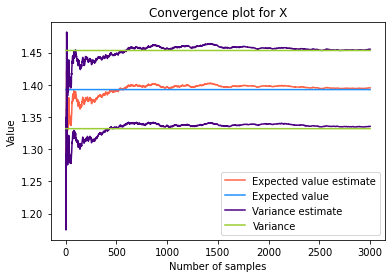

In [29]:
make_convergence_plot('X', samples_mean_x, samples_variance_x, expected_x_plot, variance_x_plot)

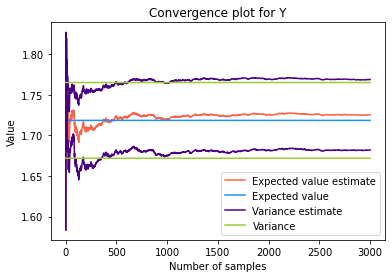

In [30]:
make_convergence_plot('Y', samples_mean_y, samples_variance_y, expected_y_plot, variance_y_plot)

Create Consistency plot

In [37]:
def make_consistency_plot(variable_name, moment_name, samples, expected_value, save=True):
    """
    Creates consistency plot for given variable and moment (i.e. mean or variance)
    Args:
        variable_name (_type_): name of the variable - i.e. X or Y
        moment_name (_type_): name of the moment - i.e. mean or variance
        samples (_type_): N x 2 array of samples and their corresponding moment (rows of generated sets)
        expected (_type_): expected value of the moment
        save (bool, optional): save to file if set to True. Defaults to True.
    """
    
    plt.plot(*zip(*expected_value), color='dodgerblue', label=moment_name)
    for sample in samples:
        plt.plot(*zip(*sample), color='salmon', alpha=.6)
    
    plt.legend()
    plt.title(f'Consistency plot for {moment_name} of {variable_name}')
    plt.xlabel('Number of samples')
    plt.ylabel('Value')
    
    if save:
        # Save to file
        plt.savefig(f'consistency_{moment_name}_{variable_name}', dpi=600)
    
    plt.show()
    


In [38]:
n_sample_sets = 5

# This will comprise list of 4-tuples (mean_x, mean_y, var_x, var_y)
samples = [generate_sample_set(1000) for _ in range(n_sample_sets)] # to better visualize we only use 1k samples instead of 3k before


consistency_mean_x = [sample[0] for sample in samples]
consistency_mean_y = [sample[1] for sample in samples]
consistency_var_x = [sample[2] for sample in samples]
consistency_var_y = [sample[3] for sample in samples]


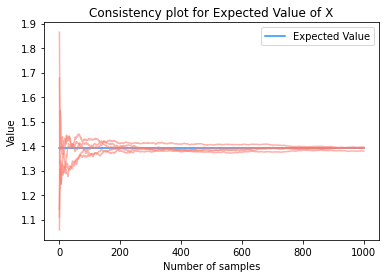

In [39]:
make_consistency_plot('X', 'Expected Value', consistency_mean_x, expected_x_plot[:1000])

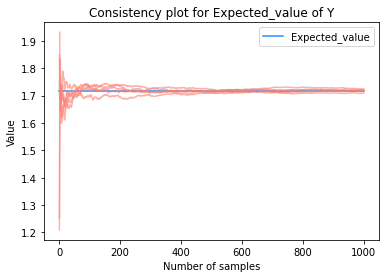

In [40]:
make_consistency_plot('Y', 'Expected_value', consistency_mean_y, expected_y_plot[:1000])

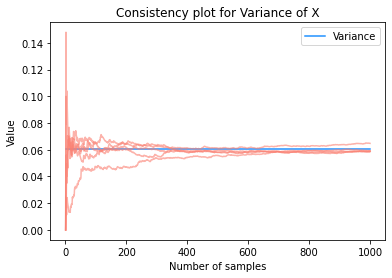

In [41]:
make_consistency_plot('X', 'Variance', consistency_var_x, variance_x_plot[:1000])

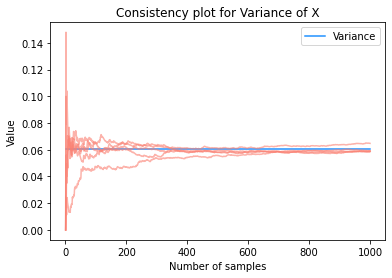

In [42]:
make_consistency_plot('X', 'Variance', consistency_var_x, variance_x_plot[:1000])

## Rejection / acceptation visualization

Here we visualize number of accepted and rejected samples for sample size of 1k

In [43]:

# Same function as above but we also return rejected samples
def generate_samples(count=10_000, rng=np_rng):
    start, end = 1, 2
    fx_max = f((2, 2))  # calculate max value of fx
    u = np_rng.uniform(0, 1, 2*count)
    u = u.reshape(-1, 2)
    x = start + (end - start) * u
    v = np_rng.uniform(0, 1, count)
    fx = x[:, 0] * x[:, 1]
    accepted = (v * fx_max < fx) & (x[:, 0] < x[:, 1])
    return x[accepted], x[~accepted]
    

In [44]:
accepted, rejected = generate_samples(1000)

accepted[:5], rejected[:5]

(array([[1.4281018 , 1.46299341],
        [1.10901271, 1.6697878 ],
        [1.18373685, 1.49924091],
        [1.16298841, 1.62868797],
        [1.4318968 , 1.64870526]]),
 array([[1.8979147 , 1.56568915],
        [1.07075768, 1.97431076],
        [1.64809126, 1.41755384],
        [1.66105094, 1.35665325],
        [1.69317588, 1.53179655]]))

In [45]:
accepted.shape

(319, 2)

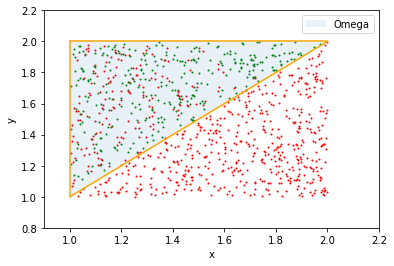

In [50]:
x_range = np.linspace(1, 2, 100)  # range of random variable X
f1 = x_range
# f2 will simply be plotted as a line because it is not a y = f(x) function
f3 = 2 * np.ones_like(x_range)

def make_plot(output_name, show_rejected=False):
    plt.plot(x_range, f1, color='orange')
    plt.plot((1, 1), (1, 2), color='orange')
    plt.plot(x_range, f3, color='orange')
    plt.scatter(accepted[:, 0], accepted[:, 1], color='green', s=1)
    if show_rejected:
        plt.scatter(rejected[:, 0], rejected[:, 1], color='red', s=1)

    plt.fill_between(x_range, x_range, 2 * np.ones_like(x_range), alpha=0.3, label=r'Omega')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(left=.9, right=2.2)
    plt.ylim(bottom=.8, top=2.2)

    plt.savefig(output_name, dpi=600)
    plt.show()

make_plot('visualization_with_rejections.png', show_rejected=True)

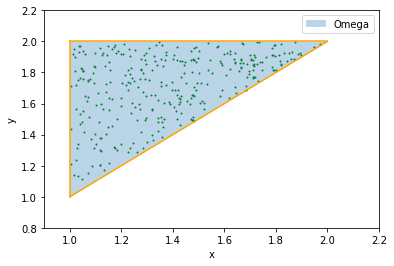

In [49]:
make_plot('visualization_wo_rejections.png', False)